# An FEM solution to the Advection-Diffusion Equation

We would like to use FEM to solve the **galerkin** form of the AD equation. 

#### Strong form of the incompressible advection-diffusion equation:
$$\mathbf{a} \cdot \nabla \mathbf{u} - \nabla \cdot (k \nabla \mathbf{u}) - \mathbf{f} = \mathbf{0} \quad \text{s.t.} \ \ \mathbf{u} = \mathbf{g} \ \ \text{on} \ \ \Gamma $$
or
$$\mathcal{L}(\mathbf{u}) - \mathbf{f} = \mathbf{0} \quad \text{s.t.} \ \ \mathbf{u} = \mathbf{g} \ \ \text{on} \ \ \Gamma$$

#### Weak form of the incompressible advection-diffusion equation:
$$\int_\Omega \mathbf{w} \cdot \big( \mathbf{a} \cdot \nabla \mathbf{u} - \nabla \cdot (k \nabla \mathbf{u}) - \mathbf{f} \big) \, {\rm d}\Omega = 0 \quad \text{s.t.} \ \ \mathbf{u} = \mathbf{g} \ \ \text{on} \ \ \Gamma $$

Integration by parts and noting the vanishing of test function on $\Gamma$:
$$\int_\Omega \mathbf{w} \cdot ( \mathbf{a} \cdot \nabla \mathbf{u} ) \, {\rm d}\Omega + \int_\Omega \nabla \mathbf{w} \cdot (k \nabla \mathbf{u}) \, {\rm d}\Omega - \int_\Omega \mathbf{w} \cdot \mathbf{f} \, {\rm d}\Omega = 0 \quad \text{s.t.} \ \ \mathbf{u} = \mathbf{g} \ \ \text{on} \ \ \Gamma$$ 
or
$$B(\mathbf{w},\mathbf{u}) = (\mathbf{w},\mathbf{f}) \quad \text{s.t.} \ \ \mathbf{u} = \mathbf{g} \ \ \text{on} \ \ \Gamma$$

### Galerkin's method
Find $\mathbf{u}^h = \mathbf{v}^h + \mathbf{g}^h$ where $\mathbf{v}^h \in \mathcal{V}^h$ s.t. $\forall \mathbf{w}^h \in \mathcal{V}^h$: $B(\mathbf{w}^h,\mathbf{u}^h) = 0$
$$\mathbf{v}^h(\mathbf{x}) = \sum_{A=1}^N \mathbf{v}_A N_A(\mathbf{x})$$
$$\mathbf{w}^h(\mathbf{x}) = \sum_{A=1}^N \mathbf{w}_B N_B(\mathbf{x})$$

#### Consider the 1D case with $\Omega = [0,L]$:
$$B(w,u) = \int_0^L w \, a \dfrac{{\rm d}u}{{\rm d}x} \, {\rm d}x + \int_0^L \dfrac{{\rm d}w}{{\rm d}x} k \dfrac{{\rm d}u}{{\rm d}x} \, {\rm d}x = \int_0^L w \, f \, {\rm d}x$$

**Galerkin** - Consider a discretization with $NC$ number of control points (i.e., FE nodes)
$$\sum_{b=1}^{NC} \big(K^{\rm adv}_{ab} + K^{\rm diff}_{ab}\big) \, u_b = F_a, \qquad \forall a=1,...,NC$$
$$K^{\rm adv}_{ab} = \int_{-1}^{1} N_a \, a \, \dfrac{{\rm d}N_b}{{\rm d}\xi} \, {\rm d}\xi$$

$$K^{\rm diff}_{ab} = \int_{-1}^{1} \dfrac{{\rm d}N_a}{{\rm d}\xi} \, k \, \dfrac{{\rm d}N_b}{{\rm d}\xi} \, \dfrac{{\rm d}\xi}{{\rm d}x} \, {\rm d}\xi$$

$$F_{a} = \int_{-1}^{1} N_a \, f \, \dfrac{{\rm d}x}{{\rm d}\xi} \, {\rm d}\xi$$

### The objective here is to study the role of *convective* velocity on stability and add the SUPG stabilization to the system.

Add the SUPG term to the system:
$$B_{\rm SUPG}(w^h,u^h) = \int_0^L a \, \dfrac{{\rm d}w^h}{{\rm d}x} \tau \big( \mathcal{L}(u^h) - f \big) \, {\rm d}x $$

Note that the stabilization parameter $\tau$ is defined on the element level:
$$\tau_e = \dfrac{h_e}{2a} \min{\! \big(\dfrac{\alpha_e}{3}, 1 \big)}$$

Considering that for a linear FE system, $\dfrac{{\rm d}}{{\rm d}x} \Big(k \dfrac{{\rm d}u}{{\rm d}x}\Big) = 0$
$$K^{\rm SUPG}_{ab} = \int_{-1}^{1} a^2 \, \tau \, \dfrac{{\rm d}N_a}{{\rm d}\xi} \, \dfrac{{\rm d}N_b}{{\rm d}\xi} \, \dfrac{{\rm d}\xi}{{\rm d}x} \, {\rm d}\xi$$

$$F^{\rm SUPG}_{a} = \int_{-1}^{1} a \, \tau \, \dfrac{{\rm d}N_a}{{\rm d}\xi} \, f \, {\rm d}\xi$$

#### Let's start coding!

Import the required python modules for this code:

In [1]:
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

#### Adopting the object-oriented programming, we write the following Python *class*:

In [2]:
class advectionDiffusionFEM():

    def __init__(self, L, num_elem, convective_vel, diffusivity, f, u0, uL, ADD_SUPG=True):
        """
            Initialize the model.
           
            input: L -> the size of domain
            input: num_elem -> the number of elements in the analysis
            input: conv_vel -> the convective velocity
            input: u0, uL -> essential boundary conditions
            input: ADD_SUPG -> flag to indicate whether SUPG stabilization is added to the system
            output: the model problem object
        """
        
        #Discretize a 1D domain (0,L) into a number of elements and store the nodal positions
        #We are using linear shape functions, therefore, there are two nodes in each element
        nodes = np.linspace(0,L,num_elem+1)
        
        #1D case
        self.X = nodes
        
        #Create the connectivity matrix for bookkeeping purposes
        #Each row in connect contains the nodal numbers for each element, starting from element 1
        #Considering that there are two nodes in each element:
        self.connect = np.zeros((num_elem,2), dtype=np.int)
        for i in range(num_elem):
            self.connect[i] = [i,i+1]
            
        self.L = L
        self.num_elem = num_elem
        
        #Create an array containing the element size
        #In this case, we have linear elements
        self.h = self.X[1:] - self.X[:-1]
        
        #Each node has 1 degree of freedom
        self.num_dof = nodes.size
        
        #Store the involved parameters
        self.a = convective_vel
        self.k = diffusivity
        self.f = f
        self.u0 = u0
        self.uL = uL
        
        self.ADD_SUPG = ADD_SUPG
        
        #Let's calculate the SUPG constant in the initialization phase
        if self.ADD_SUPG:
            self.compute_SUPG_constant()
        
    def compute_SUPG_constant(self):
        """Compute the SUPG constant for each element."""
        
        self.alpha = self.a * self.h / (2*self.k)
        
        self.tau = self.h / (2*self.a) * np.minimum(self.alpha/3, 1)

    def N(self, xi):
        """Compute linear shape functions in parametric coordinates."""
        
        return [1 / 2. * (1 - xi),
                1 / 2. * (1 + xi)]

    def dNdxi(self, xi):
        """Compute linear shape function derivatives with respect to xi"""

        return [-1 / 2.,
                1 / 2.]
    
    def compute_jacobian_matrix_and_inverse(self, xi):
        """
           Compute the Jacobian matrix and det(J) for every element
        """
        
        #Understand we are broadcasting the dot product to every element
        J = np.dot(self.X[self.connect], self.dNdxi(xi))
        
        #detJ is a vector containing the Jacobian determinant for every element
        self.detJ = J
        
        self.Jinv = 1. / self.detJ       

    def compute_k_adv_integrand(self, xi):
        """Computes the k_adv integrand matrix for a given xi"""
            
        #Returns detJ and Jinv components for this xi
        #self.compute_jacobian_matrix_and_inverse(xi) #we don't need the jacobians here

        this_N = self.N(xi)
        this_dN = self.dNdxi(xi)
            
        #ke_adv[ab] = a N[a] dN_dxi[b]
        return np.einsum(',a,b->ab', self.a, this_N, this_dN) # this turns out the same for every element 

    def integrate_k_adv_matrix(self):
        """Integrate k_adv matrix with Gauss integration"""
            
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        ke = np.zeros((self.num_elem, 2, 2))
            
        for i in range(num_gauss_points):
            ke += wts[i] * self.compute_k_adv_integrand(pts[i])
                    
        return ke  

    def compute_k_diff_integrand(self, xi):
        """Computes the k_diff integrand matrix for a given xi"""
            
        #Returns detJ and Jinv components for this xi
        self.compute_jacobian_matrix_and_inverse(xi)

        this_dN = self.dNdxi(xi)
            
        #ke_diff[ab] = k dN_dxi[a] dN_dxi[b] dxi_dx
        return np.einsum(',a,b,m->mab', self.k, this_dN, this_dN, self.Jinv)

    def integrate_k_diff_matrix(self):
        """Integrate k_diff matrix with Gauss integration"""
            
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        ke = np.zeros((self.num_elem, 2, 2))
            
        for i in range(num_gauss_points):
            ke += wts[i] * self.compute_k_diff_integrand(pts[i])
                    
        return ke

    def compute_k_supg_integrand(self, xi):
        """Computes the k_supg integrand matrix for a given xi"""
            
        #Returns detJ and Jinv components for this xi
        self.compute_jacobian_matrix_and_inverse(xi)

        this_dN = self.dNdxi(xi)
            
        #ke_diff[ab] = k dN_dxi[a] dN_dxi[b] dxi_dx
        return np.einsum(',m,a,b,m->mab', self.a*self.a, self.tau, this_dN, this_dN, self.Jinv)

    def integrate_k_supg_matrix(self):
        """Integrate k_supg matrix with Gauss integration"""
            
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        ke = np.zeros((self.num_elem, 2, 2))
            
        for i in range(num_gauss_points):
            ke += wts[i] * self.compute_k_supg_integrand(pts[i])
                    
        return ke

    def compute_f_integrand(self, xi):
        """Computes the f integrand vector for a given xi"""
            
        #Returns detJ and Jinv components for this xi
        self.compute_jacobian_matrix_and_inverse(xi)

        this_N = self.N(xi)
            
        #fe[a] = N[a] f dx_dxi
        return np.einsum('a,,m->ma', this_N, self.f, self.detJ)

    def integrate_f_vector(self):
        """Integrate F vector with Gauss integration"""
            
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        fe = np.zeros((self.num_elem, 2))
            
        for i in range(num_gauss_points):
            fe += wts[i] * self.compute_f_integrand(pts[i])
                    
        return fe

    def compute_f_supg_integrand(self, xi):
        """Computes the f_supg integrand vector for a given xi"""

        this_dN = self.dNdxi(xi)
            
        #fe[a] = N[a] f dx_dxi
        return np.einsum(',m,a,->ma', self.a, self.tau, this_dN, self.f)

    def integrate_f_supg_vector(self):
        """Integrate F_supg vector with Gauss integration"""
            
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        fe = np.zeros((self.num_elem, 2))
            
        for i in range(num_gauss_points):
            fe += wts[i] * self.compute_f_supg_integrand(pts[i])
                    
        return fe

    def assemble(self):
        """Assemble element stiffness into global"""
        
        #Allocate global tangent and r.h.s vector
        self.Kmat = np.zeros((self.num_dof, self.num_dof), dtype=np.double)
        self.Fvec = np.zeros(self.num_dof, dtype=np.double)
        
        #Calculate the tangent and source terms on the local elements
        ke_adv = self.integrate_k_adv_matrix()
        ke_diff = self.integrate_k_diff_matrix()
        fe = self.integrate_f_vector()
        
        if self.ADD_SUPG:
            ke_supg = self.integrate_k_supg_matrix()
            fe_supg = self.integrate_f_supg_vector()
    
        for i in range(self.num_elem):
            idx_grid = np.ix_(self.connect[i], self.connect[i])
            self.Kmat[idx_grid] += ke_adv[i]
            self.Kmat[idx_grid] += ke_diff[i]
            if self.ADD_SUPG:
                self.Kmat[idx_grid] += ke_supg[i]
    
        for i in range(self.num_elem):
            idx_grid = self.connect[i]
            self.Fvec[idx_grid] += fe[i]
            if self.ADD_SUPG:
                self.Fvec[idx_grid] += fe_supg[i]
            
            
        #Add the SUPG contribution to the system
        

    def apply_essential_bc(self):
        """
           Modifies l.h.s. matrix and r.h.s. vector for essential b.c.s.
        """
        
        row_replace = np.zeros(self.num_dof)
      
        #x=0 (first node)
        self.Kmat[0] = row_replace
        self.Kmat[0,0] = 1
        self.Fvec[0] = self.u0
      
        #x=L (last node)
        self.Kmat[-1] = row_replace
        self.Kmat[-1,-1] = 1
        self.Fvec[-1] = self.uL
            
    def solve(self):
        """Solve the global system of equations"""
        
        #Convert to a sparse type matrix
        self.Kmat = scipy.sparse.csr_matrix(self.Kmat)
        
        #Solve the system
        U = scipy.sparse.linalg.spsolve(self.Kmat,self.Fvec)
        #U = np.linalg.solve(self.Kmat, self.Fvec)
        
        #We got the solution
        self.u = U 
            
    def eval_exact_sol(self):
        """Evaluate the exact solution at all the nodes"""
        
        if self.a != 0.0:
            # u_ex = c1 + c2 exp(ax/k) + fx/a

            # bcs
            # 1. c1 + c2 = U0
            # 2. c1 + c2 exp(aL/k) = UL - fL/a

            c2 = (self.uL - self.u0 - self.f * self.L / self.a) / (np.exp(self.a * self.L / self.k) - 1.)
            c1 = self.u0 - c2

            self.u_ex = c1 + c2 * np.exp(self.a * self.X / self.k) + self.f * self.X / self.a
            
        else:
            # u_ex = c1 + c2 x - fx^2/2k

            # bcs
            # 1. c1 = U0
            # 2. c1 + c2 L = UL + fL^2/2k
            
            c1 = self.u0
            c2 = (self.uL - self.u0 + self.f * self.L**2 / (2. * self.k)) / self.L

            self.u_ex = c1 + c2 * self.X - self.f * self.X**2 / (2. * self.k)
            
    def eval_exact_sol_at_x(self, x):
        """Evaluate the exact solution at a given (array of) points"""
        
        if self.a != 0.0:
            # u_ex = c1 + c2 exp(ax/k) + fx/a

            # bcs
            # 1. c1 + c2 = U0
            # 2. c1 + c2 exp(aL/k) = UL - fL/a

            c2 = (self.uL - self.u0 - self.f * self.L / self.a) / (np.exp(self.a * self.L / self.k) - 1.)
            c1 = self.u0 - c2

            u_ex = c1 + c2 * np.exp(self.a * x / self.k) + self.f * x / self.a
            
        else:
            # u_ex = c1 + c2 x - fx^2/2k

            # bcs
            # 1. c1 = U0
            # 2. c1 + c2 L = UL + fL^2/2k
            
            c1 = self.u0
            c2 = (self.uL - self.u0 + self.f * self.L**2 / (2. * self.k)) / self.L

            u_ex = c1 + c2 * x - self.f * x**2 / (2. * self.k)
            
        return u_ex
            
    def compute_l2_error_integrand(self, xi):
        """Compute the l2 norm error integrand"""
            
        #Returns detJ and Jinv components for this xi
        self.compute_jacobian_matrix_and_inverse(xi)

        this_N = self.N(xi)
        
        #interpolate the solution at the gauss point
        this_u = np.einsum('ma,a->m', self.u[self.connect], this_N) # u @ gauss point for each element
        
        #evaluate the exact solution at the gauss point
        this_X = np.einsum('ma,a->m', self.X[self.connect], this_N) # X @ gauss point for each element
        this_u_ex = self.eval_exact_sol_at_x(this_X)
        
        this_error = this_u - this_u_ex
        
        l2_integrand = this_error**2 * self.detJ 
            
        return l2_integrand
            
    def eval_l2_error(self):
        """Evaluate the l2 norm error"""
    
        #Use 2 Gauss integration
        num_gauss_points = 2
        
        wts = [1., 1.]
        pts = [-np.sqrt(1 / 3.), np.sqrt(1 / 3.)]
        
        l2err = np.zeros((self.num_elem))
            
        for i in range(num_gauss_points):
            l2err += wts[i] * self.compute_l2_error_integrand(pts[i])
                    
        l2err = np.sqrt(np.sum(l2err)) # now lets sum over all elements and sqrt
        
        return l2err
    

    def plot(self):
        """Make the plots"""
        
        #Velocity plot
        fig, ax = plt.subplots(figsize=(9,9))

        ax.plot(self.X, self.u, 'k', label='FEM')
        ax.plot(self.X, self.u_ex, 'ro', label='Exact')
        
        ax.legend(fontsize=20)
        ax.tick_params(labelsize=20);
        ax.set_xlabel('x', fontsize=24);
        ax.set_ylabel('u', fontsize=24);
        
        #plt.savefig("velocity.png",bbox_inches='tight') #if you would like to save it

# Here we use the class to solve a problem.

In [3]:
# Input
L = 1 # length of 1D domain
num_elem = 10 # number of elements
a = 250 # convective_vel
diffusivity = 1 # diffusivity
f = 5 # source term
u0 = 0 # essential bc (vel) @ x=0
uL = 1 # essential bc (vel) @ x=L

Let's calculate the $\alpha$ parameter to check the stability.

In [4]:
h = L / num_elem
k = diffusivity
alpha = a * h / (2*k)

print('\u03B1 =', alpha)

if alpha > 1:
    print('\u03B1 > 1 --> Warning: Your method is unstable here. Try using more elements.')
elif alpha < 1:
    print('\u03B1 < 1 --> Your method is stable here.')
else:
    print('\u03B1 = 1 --> Warning: Your method is neutrally stable here. It is better to use more elements.')

α = 12.5
α > 1 --> Warning: Your method is unstable here. Try using more elements.


#### Let's assemble the problem per input and solve it.

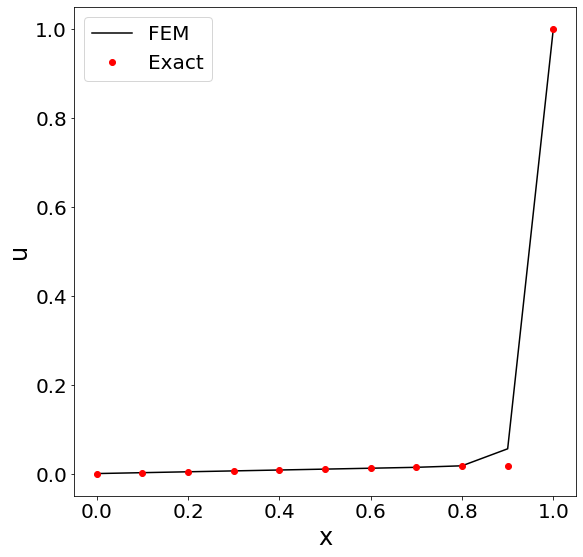

In [5]:
#Instatiate the problem
problem = advectionDiffusionFEM(L=L, 
                                num_elem=num_elem, 
                                convective_vel=a, 
                                diffusivity=k, 
                                f=f, 
                                u0=u0, 
                                uL=uL,
                                ADD_SUPG=True)

#Assemble
problem.assemble()

#Apply boundary conditions
problem.apply_essential_bc()

#Solve
problem.solve()

#Evaluate the exact solution
problem.eval_exact_sol()

#Post processing
problem.plot()

# Assignment 
1. Add the SUPG stabilization to the system.
2. Perform a convergence study for a given parameter set ($a, k, f$), considering the L2 norm. 

Note that the exact solution for a constant set of $a, k, f$ is:
$$u_{\rm ex}(x) = c_1 + c_2 \exp{(ax/k)} + f x / a$$
where $c_1$ and $c_2$ are obtained with respect to the boundary conditions $u_0$ and $u_L$.

## Convergence study 
Now that we have the SUPG implementation, we want to perform a convergence study using the base model with and without the SUPG stabilization.

$$\big|\big|\, u^h - u\, \big|\big|_{L_2(\Omega)} = \sqrt{\int_\Omega \big(u^h - u\big) \cdot \big(u^h - u\big) \, {\rm d}\Omega}$$
$$\big|\big|\, u^h - u\, \big|\big|_{L_2(\Omega)} = \sqrt{\sum_{ne} \int_{\Omega_e} \big(u^h - u\big) \cdot \big(u^h - u\big) \, {\rm d}{\Omega_e}} = \sqrt{\sum_{ne} \big|\big|\, u^h - u\, \big|\big|_{L_2(\Omega_e)}^2}$$
$$\big|\big|\, u^h - u\, \big|\big|_{L_2(\Omega_e)}^2 = \int_{-1}^{1} \big(u^h - u\big) \cdot \big(u^h - u\big) \, \dfrac{{\rm d}x}{{\rm d}\xi} \, {\rm d}\xi$$

In [16]:
# Input
L = 1 # length of 1D domain
a = 100 # convective_vel
diffusivity = 1 # diffusivity
f = 5 # source term
u0 = 0 # essential bc (vel) @ x=0
uL = 1 # essential bc (vel) @ x=L
num_elements = np.array([4,8,16,32,64,128,256,512]) # number of elements for convergence study
h_array = L/num_elements # list of h for each case

First, let's do the convergence analysis **without** SUPG.

In [17]:
l2_errors_no_supg = np.zeros(num_elements.size)

for idx, num_element in enumerate(num_elements):
    
    #Instatiate the problem
    problem = advectionDiffusionFEM(L=L, 
                                    num_elem=num_element, 
                                    convective_vel=a, 
                                    diffusivity=k, 
                                    f=f, 
                                    u0=u0, 
                                    uL=uL,
                                    ADD_SUPG=False)

    #Assemble
    problem.assemble()

    #Apply boundary conditions
    problem.apply_essential_bc()

    #Solve
    problem.solve()

    #Calculate the l2 error
    l2_errors_no_supg[idx] = problem.eval_l2_error()


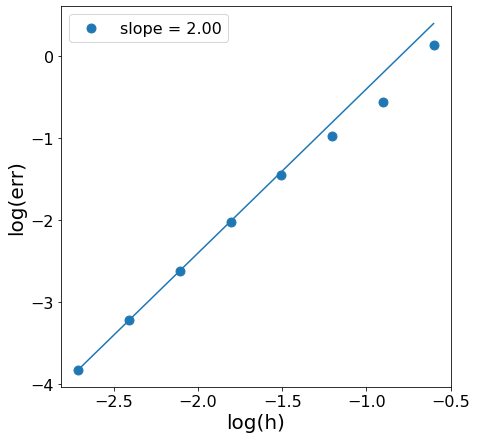

In [18]:
fig, ax = plt.subplots(figsize=(7,7))

error_array = l2_errors_no_supg

slope = 2
intercept = np.log10(error_array[-1]) - np.log10(h_array[-1])*slope

ax.plot(np.log10(h_array), np.log10(h_array)*slope + intercept);

ax.scatter(np.log10(h_array), np.log10(error_array), s=80, label='slope = %.2f' %slope);

ax.set_xlabel('log(h)', fontsize=20)
ax.set_ylabel('log(err)', fontsize=20)

ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

Now let's do the convergence analysis **with** SUPG.

In [19]:
l2_errors_no_supg = np.zeros(num_elements.size)

for idx, num_element in enumerate(num_elements):
    
    #Instatiate the problem
    problem = advectionDiffusionFEM(L=L, 
                                    num_elem=num_element, 
                                    convective_vel=a, 
                                    diffusivity=k, 
                                    f=f, 
                                    u0=u0, 
                                    uL=uL,
                                    ADD_SUPG=True)

    #Assemble
    problem.assemble()

    #Apply boundary conditions
    problem.apply_essential_bc()

    #Solve
    problem.solve()

    #Calculate the l2 error
    l2_errors_no_supg[idx] = problem.eval_l2_error()


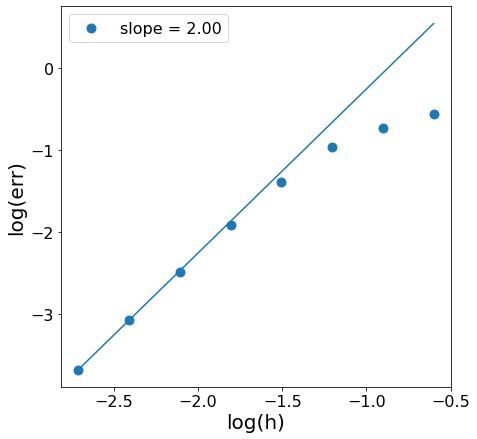

In [20]:
fig, ax = plt.subplots(figsize=(7,7))

error_array = l2_errors_no_supg

slope = 2
intercept = np.log10(error_array[-1]) - np.log10(h_array[-1])*slope

ax.plot(np.log10(h_array), np.log10(h_array)*slope + intercept);

ax.scatter(np.log10(h_array), np.log10(error_array), s=80, label='slope = %.2f' %slope);

ax.set_xlabel('log(h)', fontsize=20)
ax.set_ylabel('log(err)', fontsize=20)

ax.tick_params(labelsize=16)
ax.legend(fontsize=16)